In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import seaborn as sns 

In [3]:
# 1. EXTRACT: Load Data
def extract_data(file_path):
    """
    Extract data from CSV file
    """
    try:
        df = pd.read_csv(file_path)
        print(f"Data extracted successfully. Shape: {df.shape}")
        return df
    except Exception as e:
        print(f"Error extracting data: {e}")
        return None

# Load the data
data_path = '../data/data.csv'
df_raw = extract_data(data_path)
df_raw.head()

Data extracted successfully. Shape: (1000, 11)


,type_school,school_accreditation,gender,interest,residence,parent_age,parent_salary,house_area,average_grades,parent_was_in_college,will_go_to_college
0,Academic,A,Male,Less Interested,Urban,56,6950000,83.0,84.09,False,True
1,Academic,A,Male,Less Interested,Urban,57,4410000,76.8,86.91,False,True
2,Academic,B,Female,Very Interested,Urban,50,6500000,80.6,87.43,False,True
3,Vocational,B,Male,Very Interested,Rural,49,6600000,78.2,82.12,True,True
4,Academic,A,Female,Very Interested,Urban,57,5250000,75.1,86.79,False,False


In [4]:
# 2. TRANSFORM: Clean and Preprocess Data
def transform_data(df):
    """
    Transform the raw data: handle missing values, encode categorical variables, feature engineering
    """
    df_transformed = df.copy()

    # Check for missing values
    print("Missing values before transformation:")
    print(df_transformed.isnull().sum())

    # Handle missing values (if any)
    df_transformed = df_transformed.dropna()

    # Encode categorical variables
    categorical_cols = ['type_school', 'school_accreditation', 'gender', 'interest', 'residence']
    label_encoders = {}

    for col in categorical_cols:
        le = LabelEncoder()
        df_transformed[col] = le.fit_transform(df_transformed[col])
        label_encoders[col] = le

    # Convert boolean to int
    df_transformed['parent_was_in_college'] = df_transformed['parent_was_in_college'].astype(int)
    df_transformed['will_go_to_college'] = df_transformed['will_go_to_college'].astype(int)
 
    print(f"Data transformed successfully. Shape: {df_transformed.shape}")
    return df_transformed, label_encoders

# Transform the data
df_transformed, encoders = transform_data(df_raw)
df_transformed.head()

Missing values before transformation:
type_school              0
school_accreditation     0
gender                   0
interest                 0
residence                0
parent_age               0
parent_salary            0
house_area               0
average_grades           0
parent_was_in_college    0
will_go_to_college       0
dtype: int64
Data transformed successfully. Shape: (1000, 11)


,type_school,school_accreditation,gender,interest,residence,parent_age,parent_salary,house_area,average_grades,parent_was_in_college,will_go_to_college
0,0,0,1,1,1,56,6950000,83.0,84.09,0,1
1,0,0,1,1,1,57,4410000,76.8,86.91,0,1
2,0,1,0,4,1,50,6500000,80.6,87.43,0,1
3,1,1,1,4,0,49,6600000,78.2,82.12,1,1
4,0,0,0,4,1,57,5250000,75.1,86.79,0,0


In [5]:
# 3. LOAD: Prepare Data for Modeling
def load_data(df, target_col='will_go_to_college', test_size=0.2, random_state=42):
    """
    Load transformed data into train/test splits ready for modeling
    """
    # Separate features and target
    X = df.drop(target_col, axis=1)
    y = df[target_col]

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

    # Scale numerical features
    numerical_cols = ['parent_age', 'parent_salary', 'house_area', 'average_grades']
    scaler = StandardScaler()

    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()

    X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
    X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])

    print(f"Data loaded successfully.")
    print(f"Train shape: {X_train_scaled.shape}, Test shape: {X_test_scaled.shape}")
    print(f"Target distribution - Train: {y_train.value_counts().to_dict()}")
    print(f"Target distribution - Test: {y_test.value_counts().to_dict()}")

    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

# Load the data
X_train, X_test, y_train, y_test, scaler = load_data(df_transformed)

# Display final dataset info
print("\nFinal feature columns:")
print(X_train.columns.tolist())

Data loaded successfully.
Train shape: (800, 10), Test shape: (200, 10)
Target distribution - Train: {1: 400, 0: 400}
Target distribution - Test: {1: 100, 0: 100}

Final feature columns:
['type_school', 'school_accreditation', 'gender', 'interest', 'residence', 'parent_age', 'parent_salary', 'house_area', 'average_grades', 'parent_was_in_college']


In [7]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

In [8]:
import xgboost as xgb

# Create XGBoost classifier
xgb_model = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.05, 
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss",
    use_label_encoder=False
)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict
y_pred_boost = xgb_model.predict(X_test)
y_proba_boost = xgb_model.predict_proba(X_test)[:,1]

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred_boost))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_boost))


c:\Users\ASHU\anaconda3\envs\collegeforecast\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:24:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.87
ROC-AUC: 0.9496


Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.90      0.87       100
           1       0.89      0.84      0.87       100

    accuracy                           0.87       200
   macro avg       0.87      0.87      0.87       200
weighted avg       0.87      0.87      0.87       200



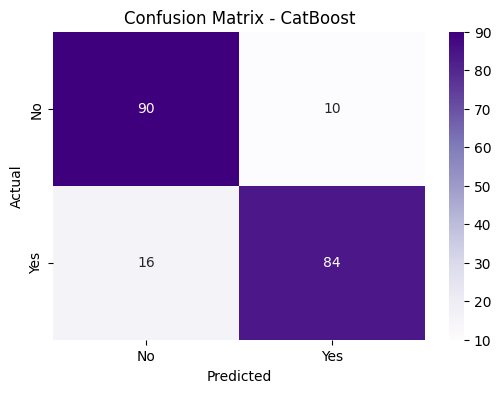

In [9]:
print("Classification Report:")
print(classification_report(y_test, y_pred_boost))

cm = confusion_matrix(y_test, y_pred_boost)

# Plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=['No','Yes'], yticklabels=['No','Yes'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - CatBoost')
plt.show()

In [10]:
import pickle

# Save model
with open("xgb_student_model.pkl", "wb") as f:
    pickle.dump(xgb_model, f)

# Assuming you have a fitted scaler: `scaler`
with open("scalerxgboost.pkl", "wb") as f:
    pickle.dump(scaler, f)
print("Saved")


Saved


In [11]:
# Save model
with open("xgb_student_model_proper.pkl", "wb") as f:
    pickle.dump(xgb_model, f)